## Import Library

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import argparse
import time
import random
from torch.utils.data import Dataset, DataLoader
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

curPath = os.path.abspath(os.path.dirname('models'))
rootPath = os.path.split(curPath)[0]
sys.path.append(rootPath)

/home/rifki/anaconda3/envs/timeseries/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Utils

In [2]:
def transfer_labels(labels):
    indicies = np.unique(labels)
    num_samples = labels.shape[0]

    for i in range(num_samples):
        new_label = np.argwhere(labels[i] == indicies)[0][0]
        labels[i] = new_label

    return labels

def collate_fn(data, device, max_len=None):
    """Build mini-batch tensors from a list of (X, mask) tuples. Mask input. Create
    Args:
        data: len(batch_size) list of tuples (X, y).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - y: torch tensor of shape (num_labels,) : class indices or numerical targets
                (for classification or regression, respectively). num_labels > 1 for multi-task models
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        targets: (batch_size, padded_length, feat_dim) torch tensor of unmasked features (output)
        target_masks: (batch_size, padded_length, feat_dim) boolean torch tensor
            0 indicates masked values to be predicted, 1 indicates unaffected/"active" feature values
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 means padding
    """

    batch_size = len(data)
    features, labels = zip(*data)

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)

    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)
    for i in range(batch_size):
        end = min(lengths[i], max_len)
        X[i, :end, :] = features[i][:end, :]

    targets = torch.stack(labels, dim=0)  # (batch_size, num_labels)

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16),
                                 max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep

    return X.to(device), targets.to(device), padding_masks.to(device)


def padding_mask(lengths, max_len=None):
    """
    Used to mask padded positions: creates a (batch_size, max_len) boolean mask from a tensor of sequence lengths,
    where 1 means keep element at this position (time step)
    """
    batch_size = lengths.numel()
    max_len = max_len or lengths.max_val()  # trick works because of overloading of 'or' operator for non-boolean types
    return (torch.arange(0, max_len, device=lengths.device)
            .type_as(lengths)
            .repeat(batch_size, 1)
            .lt(lengths.unsqueeze(1)))

def set_seed(args):
    random.seed(args.random_seed)
    np.random.seed(args.random_seed)
    torch.manual_seed(args.random_seed)
    torch.cuda.manual_seed(args.random_seed)
    torch.cuda.manual_seed_all(args.random_seed)


class HARDataset(Dataset):
    def __init__(self, dataset, target):
        # (num_size, num_dimensions, series_length)
        self.dataset = dataset.permute(0, 2, 1)
        self.target = target

    def __getitem__(self, index):
        return self.dataset[index], self.target[index]

    def __len__(self):
        return len(self.target)
    
def normalize(data_set):
    '''
    The function is the same as normalize_per_series, but can be used for multiple variables.
    '''
    return TimeSeriesScalerMeanVariance().fit_transform(data_set)

## Arguments

In [3]:
parser = argparse.ArgumentParser()

# Base setup
parser.add_argument('--backbone', type=str, default='fcn', help='encoder backbone, fcn')
parser.add_argument('--random_seed', type=int, default=42, help='shuffle seed')

# Dataset setup
parser.add_argument('--num_classes', type=int, default=0, help='number of class')
parser.add_argument('--normalize_way', type=str, default='single', help='single or train_set')
# parser.add_argument('--seq_len', type=int, default=46, help='seq_len')
parser.add_argument('--input_size', type=int, default=1, help='input_size')

# parser.add_argument('--patch_size', type=int, default=8, help='patch_size')
# parser.add_argument('--stride', type=int, default=8, help='stride')

parser.add_argument('--target_points', type=int, default=96, help='forecast horizon')

# Patch
parser.add_argument('--patch_len', type=int, default=8, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride between patch')

# Semi training
parser.add_argument('--labeled_ratio', type=float, default='0.1', help='0.1, 0.2, 0.4')

# basic config
parser.add_argument('--task_name', type=str, required=False, default='classification',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=0, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

# model define
parser.add_argument('--top_k', type=int, default=3, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=64, help='dimension of model')   ###
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=3, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=64, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=1, help='gpu')


# training setup
parser.add_argument('--loss', type=str, default='cross_entropy', help='loss function')
parser.add_argument('--optimizer', type=str, default='adam', help='optimizer')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.0, help='weight decay')
parser.add_argument('--batch_size', type=int, default=8, help='')
parser.add_argument('--epoch', type=int, default=15, help='training epoch')
parser.add_argument('--cuda', type=str, default='cuda:1')

parser.add_argument('--save_dir', type=str, default='/SSD/lz/time_series_label_noise/result')
parser.add_argument('--save_csv_name', type=str, default='timesnet_ucr_supervised_0801_')

# classifier setup
parser.add_argument('--classifier', type=str, default='linear', help='type of classifier(linear or nonlinear)')
parser.add_argument('--classifier_input', type=int, default=128, help='input dim of the classifiers')

args = parser.parse_args(args=[])

device = torch.device(args.cuda if torch.cuda.is_available() else "cpu")
set_seed(args)
args

Namespace(backbone='fcn', random_seed=42, num_classes=0, normalize_way='single', input_size=1, target_points=96, patch_len=8, stride=8, labeled_ratio=0.1, task_name='classification', freq='h', seq_len=96, label_len=48, pred_len=0, seasonal_patterns='Monthly', inverse=False, top_k=3, num_kernels=6, enc_in=7, dec_in=7, c_out=7, d_model=64, n_heads=8, e_layers=3, d_layers=1, d_ff=64, moving_avg=25, factor=1, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, use_gpu=True, gpu=1, loss='cross_entropy', optimizer='adam', lr=0.001, weight_decay=0.0, batch_size=8, epoch=15, cuda='cuda:1', save_dir='/SSD/lz/time_series_label_noise/result', save_csv_name='timesnet_ucr_supervised_0801_', classifier='linear', classifier_input=128)

## Data Preprocessing

In [4]:
train = pd.read_csv('dataset/UCI-HAR-Dataset/train.csv')
test = pd.read_csv('dataset/UCI-HAR-Dataset/test.csv')

train = train.drop('subject', axis=1)
test = test.drop('subject', axis=1)

labelNames = list(np.unique(train['Activity']))
labelNames.sort()
train['Activity'] = train['Activity'].apply(lambda x: labelNames.index(x))
test['Activity'] = test['Activity'].apply(lambda x: labelNames.index(x))

In [5]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,2
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,2
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,2
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,2
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,2


In [6]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

# Existing training and test data
x_train = train.iloc[:, :-1].to_numpy(dtype=np.float32)
y_train = train.iloc[:, -1].to_numpy(dtype=np.float32)

x_test = test.iloc[:, :-1].to_numpy(dtype=np.float32)
y_test = test.iloc[:, -1].to_numpy(dtype=np.float32)

# Define the number of classes
num_classes = len(np.unique(y_train))

In [8]:
x_train = x_train[:, :, np.newaxis]
x_test = x_test[:, :, np.newaxis]

In [9]:
args.num_classes = num_classes
args.seq_len = x_train.shape[1]
args.input_size = x_train.shape[2]

args.enc_in = x_train.shape[2]

while x_train.shape[0] * 0.6 < args.batch_size:
    args.batch_size = args.batch_size // 2

print("args.batch_size = ", args.batch_size, ", x_train.shape = ", x_train.shape, ", x_test.shape = ", x_test.shape)

args.batch_size =  8 , x_train.shape =  (7352, 561, 1) , x_test.shape =  (2947, 561, 1)


## Modelling

In [10]:
import torch
import torch.nn as nn


class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=6, init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=2 * i + 1, padding=i))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res

In [11]:
import torch
import torch.nn as nn
import math


class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=25000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(
                x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft


def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list

    # print("period.shape = ", period.shape, top_list.shape, top_list, period)
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(self, configs):
        super(TimesBlock, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.k = configs.top_k
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(configs.d_model, configs.d_ff,
                               num_kernels=configs.num_kernels),
            nn.GELU(),
            Inception_Block_V1(configs.d_ff, configs.d_model,
                               num_kernels=configs.num_kernels)
        )

    def forward(self, x):
        # print("Input shape:", x.shape)
        B, T, N = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        # print("period_list shape = ", period_list.shape, period_list)

        # print("period_list period_weight shape:", period_list.shape, period_weight.shape, self.k, self.seq_len, self.pred_len)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = (
                                 ((self.seq_len + self.pred_len) // period) + 1) * period

                # print("length = ", length, self.seq_len, self.pred_len, period)
                padding = torch.zeros([x.shape[0], (length - (self.seq_len + self.pred_len)), x.shape[2]]).to(x.device)

                # print("padding x shape = ", padding.shape, x.shape)
                out = torch.cat([x, padding], dim=1)
                # print("padding out shape = ", out.shape)
            else:
                length = (self.seq_len + self.pred_len)
                out = x

            # print("out.shape = ", out.shape, length, period, length // period, N )
            # reshape
            out = out.reshape(B, length // period, period,
                              N).permute(0, 3, 1, 2).contiguous()
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # adaptive aggregation
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(
            1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        # residual connection
        res = res + x
        return res


class TimesNetModel(nn.Module):
    """
    Paper link: https://openreview.net/pdf?id=ju_Uqw384Oq
    """

    def __init__(self, configs):
        super(TimesNetModel, self).__init__()
        self.configs = configs
        self.model = nn.ModuleList([TimesBlock(configs) for _ in range(configs.e_layers)])
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq, configs.dropout)
        self.layer = configs.e_layers
        self.layer_norm = nn.LayerNorm(configs.d_model)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(configs.dropout)

        # Define self-attention layer
        self.attention = nn.MultiheadAttention(embed_dim=configs.d_model, num_heads=configs.n_heads, dropout=configs.dropout)

        self.projection = nn.Linear(configs.d_model * configs.seq_len, configs.num_classes)


    def classification(self, x_enc, x_mark_enc):
        # Embedding
        enc_out = self.enc_embedding(x_enc, None)  # [B, T, C]

        # TimesNet Blocks
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))

        # Prepare for attention: [T, B, C]
        enc_out = enc_out.permute(1, 0, 2)

        # Apply self-attention
        attn_out, _ = self.attention(enc_out, enc_out, enc_out)

        # Residual connection and layer normalization
        enc_out = self.layer_norm(enc_out + attn_out)

        # Reshape back: [B, T, C]
        enc_out = enc_out.permute(1, 0, 2)

        # Output processing remains the same
        output = self.act(enc_out)
        output = self.dropout(output)
        output = output * x_mark_enc.unsqueeze(-1)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)
        return output

    def forward(self, x_enc, x_mark_enc, x_dec=None, x_mark_dec=None, mask=None):
        dec_out = self.classification(x_enc, x_mark_enc)
        return dec_out  # [B, N]


## Training

In [13]:
model = TimesNetModel(configs=args)

In [14]:
device = 'cuda'
model = model.to(device)

In [15]:
from torch.utils.data import DataLoader

# Normalize the training, validation, and test data if specified
if args.normalize_way == 'single':
    x_train = normalize(x_train)
    x_test = normalize(x_test)

# Convert numpy arrays to tensors and create the datasets
train_set = HARDataset(torch.from_numpy(x_train).type(torch.FloatTensor).to(device).permute(0,2,1),
                       torch.from_numpy(y_train).type(torch.FloatTensor).to(device).to(torch.int64))
test_set = HARDataset(torch.from_numpy(x_test).type(torch.FloatTensor).to(device).permute(0,2,1),
                      torch.from_numpy(y_test).type(torch.FloatTensor).to(device).to(torch.int64))

# Create DataLoaders for training, validation, and testing sets
train_loader = DataLoader(train_set, batch_size=args.batch_size, num_workers=0, drop_last=True, 
                          collate_fn=lambda x: collate_fn(x, device, max_len=args.seq_len))
test_loader = DataLoader(test_set, batch_size=args.batch_size, num_workers=0, 
                         collate_fn=lambda x: collate_fn(x, device, max_len=args.seq_len))


In [16]:
loss = nn.CrossEntropyLoss().to(device)

model_init_state = model.state_dict()

losses = []
test_accuracies = []
train_time = 0.0
end_val_epochs = []

In [17]:
import mlflow.data
import torch
from tqdm import tqdm
import mlflow
import mlflow.pytorch
from torchmetrics.classification import MulticlassAccuracy
import warnings
warnings.filterwarnings("ignore")

# Initialize MLflow
mlflow.start_run()

args.learning_rate = 0.0001
args.batch_size = 64
args.epoch = 30
early_stopping_patience = 5  # Number of epochs to wait for improvement
early_stopping_counter = 0
min_train_loss = float('inf')

# Set training data
dataset = mlflow.data.from_pandas(
    train, targets='Activity', name="UCI-HAR"
)
mlflow.log_input(dataset, "dataset")

model.load_state_dict(model_init_state)

# Define optimizer and CosineAnnealingLR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epoch, eta_min=1e-6)

train_loss = []
train_accuracy = []
num_steps = train_set.__len__() // args.batch_size

# Initialize torchmetrics accuracy
accuracy_metric = MulticlassAccuracy(num_classes=args.num_classes).to(device)  # Ensure it’s on the same device as the model

# Log initial parameters and model
mlflow.log_param("learning_rate", args.learning_rate)
mlflow.log_param("batch_size", args.batch_size)
mlflow.log_param("num_epochs", args.epoch)
mlflow.pytorch.log_model(model, "initial_model")

for epoch in range(args.epoch):
    print('Epoch {}/{}'.format(epoch + 1, args.epoch))

    epoch_train_loss = 0
    model.train()
    accuracy_metric.reset()  # Reset accuracy for each epoch

    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{args.epoch}", unit="batch") as pbar:
        for x, y, padding_x_mask in train_loader:
            optimizer.zero_grad()

            # Forward pass
            pred = model(x, padding_x_mask)
            step_loss = loss(pred, y)

            # Backward pass and optimize
            step_loss.backward()
            optimizer.step()

            # Accumulate training loss
            epoch_train_loss += step_loss.item()

            # Update accuracy
            accuracy_metric.update(pred, y)
            pbar.update(1)

    # Calculate average training loss and accuracy
    epoch_train_loss /= num_steps
    epoch_train_acc = accuracy_metric.compute().item()  # Get the final accuracy for the epoch

    # Adjust learning rate using CosineAnnealingLR
    scheduler.step()

    # Early stopping based on training loss
    if epoch_train_loss < min_train_loss:
        min_train_loss = epoch_train_loss
        early_stopping_counter = 0  # Reset counter if training loss improves
        mlflow.pytorch.log_model(model, "best_model")  # Save the best model to MLflow
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Log metrics to MLflow
    mlflow.log_metric("train_loss", epoch_train_loss, step=epoch)
    mlflow.log_metric("train_accuracy", epoch_train_acc, step=epoch)
    mlflow.log_metric("learning_rate", optimizer.param_groups[0]['lr'], step=epoch)

    print(f"Train loss: {epoch_train_loss:.4f}, Train accuracy: {epoch_train_acc:.4f}")
    print(f"Learning rate after epoch {epoch + 1}: {optimizer.param_groups[0]['lr']:.6f}")

# Log the final model
mlflow.pytorch.log_model(model, "final_model")

2024/11/18 13:05:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:05:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:05:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Epoch 1/30


Epoch 1/30: 100%|██████████| 919/919 [02:47<00:00,  5.49batch/s]
2024/11/18 13:08:05 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:08:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:08:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mode

Train loss: 0.9091, Train accuracy: 0.7180
Learning rate after epoch 1: 0.000100
Epoch 2/30


Epoch 2/30: 100%|██████████| 919/919 [02:46<00:00,  5.53batch/s]
2024/11/18 13:10:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:10:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:10:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mode

Train loss: 0.2899, Train accuracy: 0.8938
Learning rate after epoch 2: 0.000099
Epoch 3/30


Epoch 3/30: 100%|██████████| 919/919 [02:47<00:00,  5.49batch/s]
2024/11/18 13:13:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:13:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:13:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mode

Train loss: 0.1664, Train accuracy: 0.9373
Learning rate after epoch 3: 0.000098
Epoch 4/30


Epoch 4/30: 100%|██████████| 919/919 [02:46<00:00,  5.52batch/s]
2024/11/18 13:16:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:16:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:16:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mode

Train loss: 0.1301, Train accuracy: 0.9530
Learning rate after epoch 4: 0.000096
Epoch 5/30


Epoch 5/30: 100%|██████████| 919/919 [02:45<00:00,  5.56batch/s]
2024/11/18 13:19:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:19:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:19:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mode

Train loss: 0.0979, Train accuracy: 0.9636
Learning rate after epoch 5: 0.000093
Epoch 6/30


Epoch 6/30: 100%|██████████| 919/919 [02:45<00:00,  5.55batch/s]
2024/11/18 13:22:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:22:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:22:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mode

Train loss: 0.0852, Train accuracy: 0.9694
Learning rate after epoch 6: 0.000091
Epoch 7/30


Epoch 7/30: 100%|██████████| 919/919 [02:44<00:00,  5.58batch/s]
2024/11/18 13:25:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:25:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:25:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mode

Train loss: 0.0633, Train accuracy: 0.9758
Learning rate after epoch 7: 0.000087
Epoch 8/30


Epoch 8/30: 100%|██████████| 919/919 [02:45<00:00,  5.56batch/s]
2024/11/18 13:27:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:27:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:27:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mode

Train loss: 0.0505, Train accuracy: 0.9816
Learning rate after epoch 8: 0.000084
Epoch 9/30


Epoch 9/30: 100%|██████████| 919/919 [02:46<00:00,  5.52batch/s]
2024/11/18 13:30:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:30:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:30:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mode

Train loss: 0.0483, Train accuracy: 0.9826
Learning rate after epoch 9: 0.000080
Epoch 10/30


Epoch 10/30: 100%|██████████| 919/919 [02:46<00:00,  5.53batch/s]
2024/11/18 13:33:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:33:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:33:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0369, Train accuracy: 0.9871
Learning rate after epoch 10: 0.000075
Epoch 11/30


Epoch 11/30: 100%|██████████| 919/919 [02:45<00:00,  5.55batch/s]


Train loss: 0.0535, Train accuracy: 0.9809
Learning rate after epoch 11: 0.000071
Epoch 12/30


Epoch 12/30: 100%|██████████| 919/919 [02:45<00:00,  5.55batch/s]
2024/11/18 13:39:01 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:39:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:39:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0345, Train accuracy: 0.9875
Learning rate after epoch 12: 0.000066
Epoch 13/30


Epoch 13/30: 100%|██████████| 919/919 [02:44<00:00,  5.57batch/s]
2024/11/18 13:41:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:41:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:41:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0263, Train accuracy: 0.9905
Learning rate after epoch 13: 0.000061
Epoch 14/30


Epoch 14/30: 100%|██████████| 919/919 [02:35<00:00,  5.90batch/s]
2024/11/18 13:44:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:44:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:44:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0246, Train accuracy: 0.9916
Learning rate after epoch 14: 0.000056
Epoch 15/30


Epoch 15/30: 100%|██████████| 919/919 [02:40<00:00,  5.72batch/s]
2024/11/18 13:47:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:47:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:47:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0243, Train accuracy: 0.9918
Learning rate after epoch 15: 0.000051
Epoch 16/30


Epoch 16/30: 100%|██████████| 919/919 [02:42<00:00,  5.66batch/s]


Train loss: 0.0246, Train accuracy: 0.9921
Learning rate after epoch 16: 0.000045
Epoch 17/30


Epoch 17/30: 100%|██████████| 919/919 [02:42<00:00,  5.65batch/s]


Train loss: 0.0252, Train accuracy: 0.9911
Learning rate after epoch 17: 0.000040
Epoch 18/30


Epoch 18/30: 100%|██████████| 919/919 [02:40<00:00,  5.74batch/s]
2024/11/18 13:55:18 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:55:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:55:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0231, Train accuracy: 0.9917
Learning rate after epoch 18: 0.000035
Epoch 19/30


Epoch 19/30: 100%|██████████| 919/919 [02:38<00:00,  5.78batch/s]
2024/11/18 13:58:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:58:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 13:58:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0226, Train accuracy: 0.9926
Learning rate after epoch 19: 0.000030
Epoch 20/30


Epoch 20/30: 100%|██████████| 919/919 [02:35<00:00,  5.90batch/s]
2024/11/18 14:00:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:00:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:00:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0198, Train accuracy: 0.9934
Learning rate after epoch 20: 0.000026
Epoch 21/30


Epoch 21/30: 100%|██████████| 919/919 [02:41<00:00,  5.68batch/s]
2024/11/18 14:03:24 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:03:26 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:03:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0176, Train accuracy: 0.9935
Learning rate after epoch 21: 0.000021
Epoch 22/30


Epoch 22/30: 100%|██████████| 919/919 [02:41<00:00,  5.70batch/s]
2024/11/18 14:06:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:06:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:06:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0160, Train accuracy: 0.9952
Learning rate after epoch 22: 0.000017
Epoch 23/30


Epoch 23/30: 100%|██████████| 919/919 [02:39<00:00,  5.77batch/s]
2024/11/18 14:08:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:08:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:08:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0120, Train accuracy: 0.9960
Learning rate after epoch 23: 0.000014
Epoch 24/30


Epoch 24/30: 100%|██████████| 919/919 [02:38<00:00,  5.80batch/s]
2024/11/18 14:11:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:11:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:11:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0116, Train accuracy: 0.9961
Learning rate after epoch 24: 0.000010
Epoch 25/30


Epoch 25/30: 100%|██████████| 919/919 [02:37<00:00,  5.82batch/s]
2024/11/18 14:14:12 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:14:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:14:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0097, Train accuracy: 0.9969
Learning rate after epoch 25: 0.000008
Epoch 26/30


Epoch 26/30: 100%|██████████| 919/919 [02:40<00:00,  5.71batch/s]
2024/11/18 14:16:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:16:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:16:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0079, Train accuracy: 0.9983
Learning rate after epoch 26: 0.000005
Epoch 27/30


Epoch 27/30: 100%|██████████| 919/919 [02:45<00:00,  5.57batch/s]
2024/11/18 14:19:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:19:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:19:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0076, Train accuracy: 0.9976
Learning rate after epoch 27: 0.000003
Epoch 28/30


Epoch 28/30: 100%|██████████| 919/919 [02:42<00:00,  5.66batch/s]
2024/11/18 14:22:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:22:31 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:22:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0075, Train accuracy: 0.9977
Learning rate after epoch 28: 0.000002
Epoch 29/30


Epoch 29/30: 100%|██████████| 919/919 [02:35<00:00,  5.91batch/s]
2024/11/18 14:25:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:25:10 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:25:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0065, Train accuracy: 0.9986
Learning rate after epoch 29: 0.000001
Epoch 30/30


Epoch 30/30: 100%|██████████| 919/919 [02:33<00:00,  5.98batch/s]
2024/11/18 14:27:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:27:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:27:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the mod

Train loss: 0.0060, Train accuracy: 0.9984
Learning rate after epoch 30: 0.000001


2024/11/18 14:27:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/18 14:27:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Testing

In [18]:
import torch
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall,
    MulticlassConfusionMatrix, MulticlassROC
)
import mlflow
import mlflow.pytorch

# Initialize metrics
accuracy_metric = MulticlassAccuracy(num_classes=args.num_classes).to(device)
f1_score_metric = MulticlassF1Score(average='macro', num_classes=args.num_classes).to(device)
precision_metric = MulticlassPrecision(average='macro', num_classes=args.num_classes).to(device)
recall_metric = MulticlassRecall(average='macro', num_classes=args.num_classes).to(device)
confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=args.num_classes).to(device)
roc_metric = MulticlassROC(num_classes=args.num_classes).to(device)

# Set the model to evaluation mode
model.eval()
test_loss = 0
loss_func = nn.CrossEntropyLoss().to(device)

# No need to compute gradients for evaluation
with torch.no_grad():
    for x, y, padding_x_mask in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x, padding_x_mask)
        loss = loss_func(pred, y)
        test_loss += loss.item()

        # Update metrics
        accuracy_metric.update(pred, y)
        f1_score_metric.update(pred, y)
        precision_metric.update(pred, y)
        recall_metric.update(pred, y)
        confusion_matrix_metric.update(pred, y)
        roc_metric.update(pred, y)

# Compute average test loss and finalize metrics
test_loss /= len(test_loader)
test_accuracy = accuracy_metric.compute().item()
test_f1_score = f1_score_metric.compute().item()
test_precision = precision_metric.compute().item()
test_recall = recall_metric.compute().item()
confusion_matrix = confusion_matrix_metric.compute()
roc_curves = roc_metric.compute()  # This provides the ROC for each class

# Log test metrics to MLflow
mlflow.log_metric("test_loss", test_loss)
mlflow.log_metric("test_accuracy", test_accuracy)
mlflow.log_metric("test_f1_score", test_f1_score)
mlflow.log_metric("test_precision", test_precision)
mlflow.log_metric("test_recall", test_recall)

# Print test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
      f"Test F1 Score: {test_f1_score:.4f}, Test Precision: {test_precision:.4f}, "
      f"Test Recall: {test_recall:.4f}")

# End the MLflow run
mlflow.end_run()


Test Loss: 0.1505, Test Accuracy: 0.9607, Test F1 Score: 0.9615, Test Precision: 0.9634, Test Recall: 0.9607


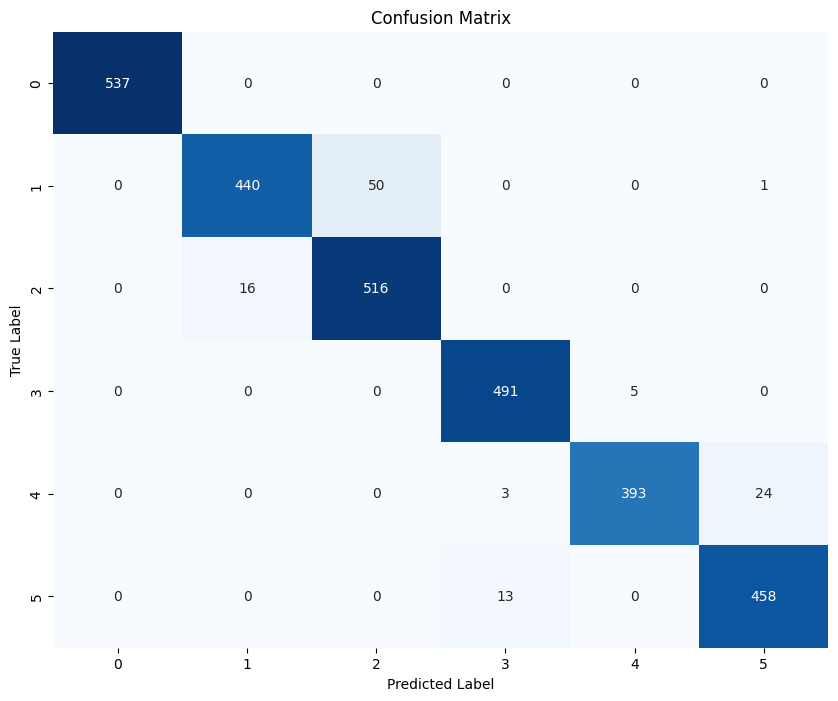

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = confusion_matrix_metric.compute().cpu().numpy()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

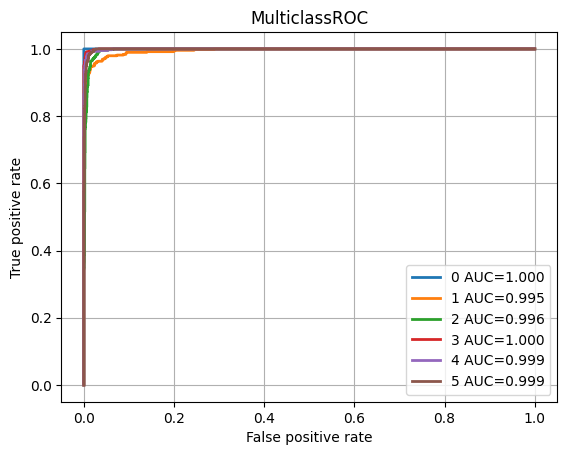

In [20]:
fig_, ax_ = roc_metric.plot(score=True)